# MNIST Digit Classification using PyTorch

This project implements a **very basic neural network** to classify handwritten digits from the MNIST dataset using PyTorch. The model achieves 95% accuracy on the test set.

In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms

In [16]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Will be using:", device)

Will be using: cuda


## Dataset Overview

MNIST is like the "Hello World" of machine learning. It's a dataset of 70,000 handwritten digits that has been used to train and test machine learning models for decades. Each image is a 28×28 pixel grayscale picture of a single digit from 0 to 9.

The dataset includes:
- 60,000 training images
- 10,000 test images
- 28×28 pixel resolution
- Grayscale format
- 10 possible classes (digits 0-9)

In [15]:
transform=transforms.Compose([
        transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print("Train Sample", train_dataset[0][0].shape, train_dataset[0][1], len(train_dataset))
print("Test Sample", test_dataset[0][0].shape, test_dataset[0][1], len(test_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1028, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1028, shuffle=True)

Train Sample torch.Size([1, 28, 28]) 5 60000
Test Sample torch.Size([1, 28, 28]) 7 10000


## Model Architecture
Hidden Units = 25

Why 25 neurons? It's a sweet spot I found through experimentation:

- Too few neurons (like 10) → The model struggles to learn patterns
- Too many neurons (like 100) → Takes longer to train and might memorize instead of learn
- 25 neurons → Just right for recognizing digit patterns!
---

For this project, I've designed a simple yet effective neural network with three layers. Think of it as a pipeline that processes the image through different stages:

1. **Input Layer**: 
   - Takes our flattened 28×28 image (784 pixels)
   - Each pixel becomes an input neuron

2. **Hidden Layers**: 
   - Two layers with 25 neurons each
   - ReLU activation for introducing non-linearity
   - These layers learn to recognize different features of the digits

3. **Output Layer**:
   - 10 neurons (one for each digit)
   - Gives us probabilities for each possible digit




In [4]:
class MnistModal(nn.Module):
    def __init__(self):
        super().__init__()
        in_features = 784
        hidden_units = 25
        out_features = 10

        self.layer_1 = nn.Linear(in_features=in_features, out_features=hidden_units)
        self.layer_2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer_3 = nn.Linear(in_features=hidden_units, out_features=out_features)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.reshape(-1, 784)
        x = self.layer_1(x)
        x = self.relu(x)
        x = self.layer_2(x)
        x = self.relu(x)
        x = self.layer_3(x)

        return x

model_0 = MnistModal().to(device)

model_0

MnistModal(
  (layer_1): Linear(in_features=784, out_features=25, bias=True)
  (layer_2): Linear(in_features=25, out_features=25, bias=True)
  (layer_3): Linear(in_features=25, out_features=10, bias=True)
  (relu): ReLU()
)

## The Training Setup

### Loss Function: CrossEntropyLoss
Think of this as our AI's "grading system":
- Perfect for classification tasks (like our digit recognition)
- Combines softmax activation and negative log-likelihood
- Helps the model understand how badly it messed up each guess

### Optimizer: Adam
- Learning rate = 0.02 (how big steps we take while learning)
- Why Adam?
    - Adapts the learning rate automatically
    - Generally works better than basic SGD
    - Handles different parameters at different scales well

### Accuracy Metric: MulticlassAccuracy
Our "report card":
- Straightforward: number of correct predictions ÷ total predictions
- Perfect for our 10-class problem
- Gives us a clear percentage we can understand

In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.02)

from torchmetrics import Accuracy

acc_fn = Accuracy(task="multiclass", num_classes=10).to(device)
acc_fn

MulticlassAccuracy()

## Untrained Model Prediction

Let's start with a fun experiment! Before training our model, let's see how it performs on some sample data. Think of this like asking a toddler to read numbers before teaching them - the results should be interesting! 

Looking at our results:
- Accuracy: 13.33%
- Loss: 2.29
- Model mostly predicted 4, 5, and 8

This is exactly what we expected! Without any training, our model is just making random guesses. The 13.33% accuracy is actually close to random chance (10% for 10 digits). The high loss value (2.29) indicates how uncertain and incorrect these predictions are.

This gives us a great baseline to compare against after training. It's like taking a "before" picture in a fitness journey - it'll make our progress much more apparent!

In [6]:
train_features, train_labels = next(iter(train_loader))
train_features, train_labels = train_features.to(device), train_labels.to(device)

sample_size = 30

y_logits = model_0(train_features[:sample_size])
# print("Logits:", y_logits.squeeze())

y_pred_probs = torch.softmax(y_logits, dim=1)
# print("Pred probs:", y_pred_probs.squeeze())

_, y_preds = torch.max(y_pred_probs, 1)
#y_preds = y_pred_probs.argmax(dim=1)
print("Pred labels:", y_preds)
print("Tarin labels:", train_labels[:sample_size])

accuracy = acc_fn(y_preds, train_labels[:sample_size])
print("Accuracy:", accuracy)

loss = loss_fn(y_logits, train_labels[:sample_size])
print("Loss:", loss)

Pred labels: tensor([8, 5, 5, 4, 5, 4, 5, 5, 5, 4, 5, 4, 5, 5, 5, 5, 8, 5, 8, 5, 5, 5, 5, 5,
        4, 5, 8, 5, 4, 5], device='cuda:0')
Tarin labels: tensor([3, 9, 4, 3, 2, 0, 7, 7, 2, 1, 4, 0, 1, 5, 1, 9, 8, 0, 7, 6, 1, 5, 8, 4,
        8, 2, 8, 9, 9, 4], device='cuda:0')
Accuracy: tensor(0.1333, device='cuda:0')
Loss: tensor(2.2932, device='cuda:0', grad_fn=<NllLossBackward0>)


In [7]:
epochs = 100

for epoch in range(1, epochs+1):
    model_0.train()

    for train_features, train_labels in train_loader:
        train_features, train_labels = train_features.to(device), train_labels.to(device)

        y_logits = model_0(train_features)
        y_pred_probs = torch.softmax(y_logits, dim=1)
        _, y_preds = torch.max(y_pred_probs, 1)
        
        acc = acc_fn(y_preds, train_labels)
        loss = loss_fn(y_logits, train_labels)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()


        model_0.eval()

    with torch.inference_mode():
        for test_featues, test_labels in test_loader:
            test_featues, test_labels = test_featues.to(device), test_labels.to(device)
            
            test_logits = model_0(test_featues)
            test_pred_probs = torch.softmax(test_logits, dim=1)
            _, test_preds = torch.max(test_pred_probs, 1)
            
            test_acc = acc_fn(test_preds, test_labels)
            test_loss = loss_fn(test_logits, test_labels)
    
    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")    

Epoch: 10 | Loss: 0.13 Acc: 0.96 | Test loss: 0.15 Test acc: 0.96
Epoch: 20 | Loss: 0.08 Acc: 0.97 | Test loss: 0.20 Test acc: 0.95
Epoch: 30 | Loss: 0.08 Acc: 0.97 | Test loss: 0.27 Test acc: 0.95
Epoch: 40 | Loss: 0.07 Acc: 0.98 | Test loss: 0.19 Test acc: 0.97
Epoch: 50 | Loss: 0.11 Acc: 0.97 | Test loss: 0.26 Test acc: 0.95
Epoch: 60 | Loss: 0.02 Acc: 0.99 | Test loss: 0.33 Test acc: 0.95
Epoch: 70 | Loss: 0.06 Acc: 0.99 | Test loss: 0.33 Test acc: 0.95
Epoch: 80 | Loss: 0.04 Acc: 0.99 | Test loss: 0.39 Test acc: 0.94
Epoch: 90 | Loss: 0.04 Acc: 0.99 | Test loss: 0.38 Test acc: 0.95
Epoch: 100 | Loss: 0.06 Acc: 0.98 | Test loss: 0.26 Test acc: 0.95


## Results: How Well Did We Do?
After all that training, our model achieved:
- Training Accuracy: 98% (how well it knows the training data)
- Test Accuracy: 95% (how well it handles new numbers)
- Training Time: ~5 minutes on RTX 2080

This means our AI can correctly identify 95 out of 100 new handwritten digits it's never seen before! Pretty impressive for a simple network, right?

## Sample Predictions

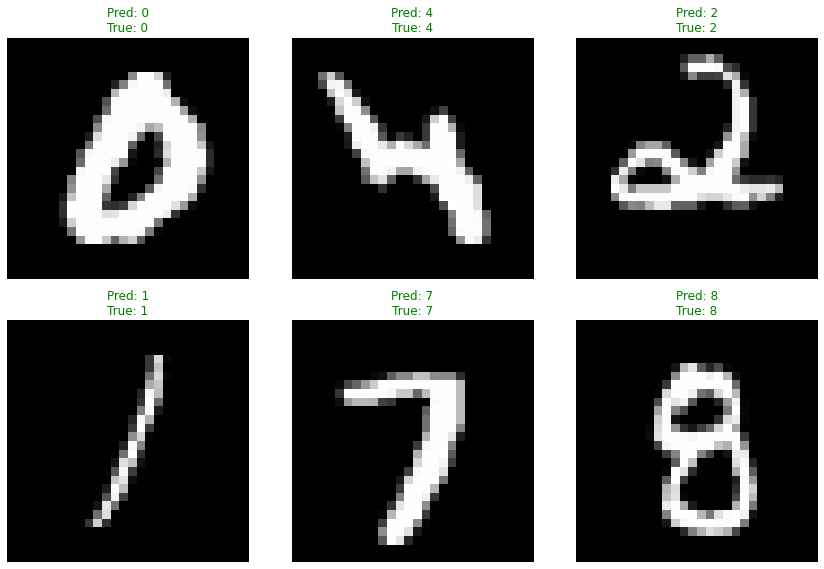

In [12]:
import matplotlib.pyplot as plt

def plot_predictions(model, test_loader, device, n_samples=6):
    """
    Plot random test images with their predictions and actual labels
    """
    # Get a random batch
    test_features, test_labels = next(iter(test_loader))
    
    # Get random indices
    rand_idx = torch.randint(0, len(test_features), (n_samples,))
    
    # Get samples
    samples = test_features[rand_idx].to(device)
    labels = test_labels[rand_idx]
    
    # Get predictions
    model.eval()
    with torch.inference_mode():
        logits = model(samples)
        predictions = torch.softmax(logits, dim=1)
        pred_labels = torch.argmax(predictions, dim=1)
    
    # Plot
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.ravel()
    
    for idx in range(n_samples):
        # Plot image
        axes[idx].imshow(samples[idx].cpu().squeeze(), cmap='gray')
        
        # Add title with prediction and actual
        title = f'Pred: {pred_labels[idx].item()}\nTrue: {labels[idx].item()}'
        axes[idx].set_title(title, color='green' if pred_labels[idx] == labels[idx] else 'red')
        
        # Remove axes
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Usage:
plot_predictions(model_0, test_loader, device)

Above are some sample predictions from our model. Green titles indicate correct predictions, while red shows where the model made mistakes. It's fascinating to see which digits the model finds tricky - sometimes they're the same ones humans might struggle with!

## Key Learnings

1. **Simple Can Be Powerful**: With just three layers and 25 neurons each, we achieved 95% accuracy. This shows that complex problems don't always need complex solutions.

2. **Consistent Performance**: Our model maintained steady accuracy across epochs, suggesting stable learning.

3. **Quick Training**: The entire training process took about 5 minutes on an RTX 2080, making it practical for experimentation.


## What's Next?

While 95% accuracy is impressive, there's always room for improvement. Here are some possible enhancements:

1. Try Convolutional Neural Networks (CNNs)
2. Experiment with different architectures
3. Add data augmentation
4. Implement dropout for better generalization

## Conclusion: What We Learned

Building this digit classifier taught us some valuable lessons:

- Simple architectures can be surprisingly effective
- The importance of choosing the right hyperparameters
- How different components (loss, optimizer, architecture) work together